# Moloco Takehome Analysis

Jeremy Chow, 09/07/2019

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Q1 a
Consider only the rows with country_id = "BDV" (there are 844 such rows). For each site_id, we can compute the number of unique user_id's found in these 844 rows. Which site_id has the largest number of unique users? And what's the number?

Import data, look at column types and format:

In [12]:
df=pd.read_csv('data/Q1_Analytics.csv')
df.head()

,ts,user_id,country_id,site_id
0,2019-02-01 00:01:24,LC36FC,TL6,N0OTG
1,2019-02-01 00:10:19,LC39B6,TL6,N0OTG
2,2019-02-01 00:21:50,LC3500,TL6,N0OTG
3,2019-02-01 00:22:50,LC374F,TL6,N0OTG
4,2019-02-01 00:23:44,LCC1C3,TL6,QGO3G


In [13]:
print(df.dtypes)
print(df.shape)

ts            object
user_id       object
country_id    object
site_id       object
dtype: object
(3553, 4)


Clean the columns

In [14]:
df['ts'] = pd.to_datetime(df.ts)

In [15]:
df_bdv=df[df.country_id == 'BDV']

In [16]:
print(df_bdv.groupby('site_id').user_id.nunique().sort_values(ascending=False).head(1))

site_id
5NPAU    544
Name: user_id, dtype: int64



# Q1 b
Between 2019-02-03 00:00:00 and 2019-02-04 23:59:59, there are four users who visited a certain site more than 10 times. Find these four users & which sites they (each) visited more than 10 times. (Simply provides four triples in the form (user_id, site_id, number of visits) in the box below.)

In [17]:
import datetime as dt

In [31]:
left_bound = dt.datetime(2019,2,3)
right_bound = dt.datetime(2019,2,5)
df_window = df[(df['ts'] >= left_bound) & (df['ts'] < right_bound)]

Find the users that visited any number of sites over 10 times.

In [41]:
df_user_pings = df_window.groupby('user_id').site_id.count().sort_values(ascending=False)
freq_users = df_user_pings[df_user_pings >= 10]
freq_users

user_id
LC3A59    26
LC06C3    26
LC3C9D    18
LC3C7E    15
Name: site_id, dtype: int64

In [54]:
df_freq_users = df_window[df_window.user_id.isin(freq_users.index.values)]

Use one hot encoding to find the counts of sites they visited, then group by user_id and sum the one-hot variables to get the total counts of visits to each site by each user.

In [57]:
user_visit_table = pd.concat([df_freq_users,(pd.get_dummies(df_freq_users['site_id']))],axis = 1).groupby('user_id').sum()
user_visit_table

,3POLC,GVOFK,N0OTG
user_id,,,
LC06C3,0,1,25
LC3A59,0,0,26
LC3C7E,15,0,0
LC3C9D,0,1,17


In [74]:
user_list=[]
most_visited_site=[]
times_visited=[]
for index,user in enumerate(user_visit_table.index.values):
    user_list.append(user)
    most_visited_site.append(user_visit_table.idxmax(axis=1)[index])
    times_visited.append(user_visit_table.max(axis=1)[user])
    print(user,user_visit_table.idxmax(axis=1)[index],user_visit_table.max(axis=1)[user])

LC06C3 N0OTG 25
LC3A59 N0OTG 26
LC3C7E 3POLC 15
LC3C9D N0OTG 17


In [93]:
df_answer = pd.DataFrame(dict({'users': user_list,'most_visited_site':most_visited_site,'times_visited':times_visited}))
df_answer

,users,most_visited_site,times_visited
0,LC06C3,N0OTG,25
1,LC3A59,N0OTG,26
2,LC3C7E,3POLC,15
3,LC3C9D,N0OTG,17


# Q1 C
For each site, compute the unique number of users whose last visit (found in the original data set) was to that site. For instance, user "LC3561"'s last visit is to "N0OTG" based on timestamp data. Based on this measure, what are top three sites? (hint: site "3POLC" is ranked at 5th with 28 users whose last visit in the data set was to 3POLC; simply provide three pairs in the form (site_id, number of users).)

In [110]:
df.groupby('user_id').last().reset_index().groupby('site_id')['user_id'].nunique().sort_values(ascending = False)

site_id
5NPAU    992
N0OTG    561
QGO3G    289
GVOFK     42
3POLC     28
RT9Z6      2
JSUUP      1
EUZ/Q      1
Name: user_id, dtype: int64

# Q2
You will find Q2 regression data from the link above. 

The data contains 300 rows and 3 columns (from the left, A, B, and C). Please build a good regression model which explains column C by a function of  A and B. 

Note: Please do not use any ML libraries or packages. You can simply attach plot of data points and your regression model that fits the data points and of course, code point (preferably Github).

In [123]:
df = pd.read_csv('data/Q2_Regression.csv', header = None)
df.columns=['A','B','C']

In [158]:
df.head()

,A,B,C
0,0.490,-0.18,11.50
1,-1.410,-1.23,11.80
2,0.943,4.51,-3.24
3,3.570,5.07,-23.90
4,-1.700,6.91,-22.10


## Preliminary Notes
If we do a pairplot to compare the distributions of all the variables, it looks like there are outliers. First thing we need to do is drop the outlier before we continue.

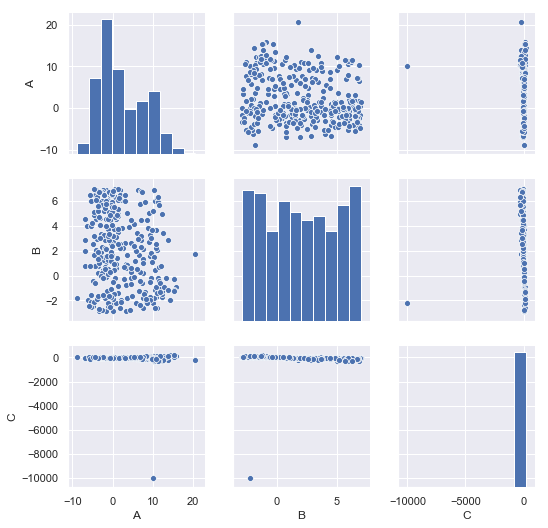

In [126]:
sns.set()
sns.pairplot(df)

In [160]:
def remove_outliers(df,column_name,number_of_std=3):
    '''Drop outliers from the dataframe, defaulting the definition of an outlier as
    3 standard deviations above or below the mean
    
    Inputs:
    df = pandas.DataFrame()
    column_name = string
    number_of_std = int, number of standard deviations away from mean to consider as an outlier 

    Output:
    DataFrame
    '''
    upper_range=df[column_name].mean() + number_of_std*df[column_name].std()
    lower_range=df[column_name].mean() - number_of_std*df[column_name].std()
    return df[(df[column_name] > lower_range) & (df[column_name] < upper_range)]


In [167]:
print(f"{df.shape[0]-remove_outliers(df,'C').shape[0]} row removed as an outlier")

1 row removed as an outlier


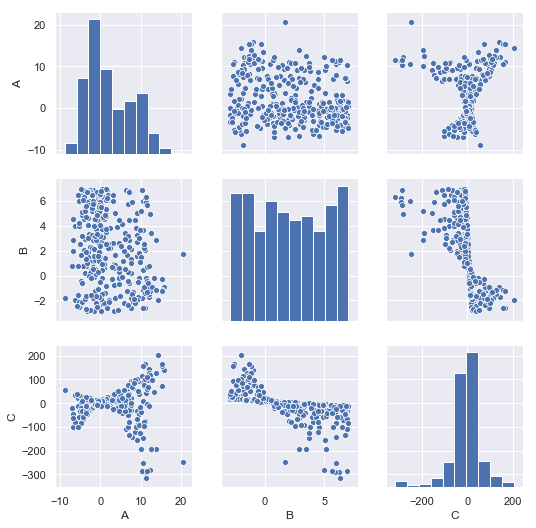

In [157]:
sns.pairplot(remove_outliers(df,'C'))

Now that we removed outliers, let's look at pairplot again to make sure conditions for linear regression are met.
1. Weak exogeneity. 
- Linearity. 
- Constant variance (a.k.a. homoscedasticity).
- Independence of errors.
- Lack of perfect multicollinearity in the predictors. 

1. We assume that A and B are the primary influencing factors over C.
- It looks like there may possibly be a linear relationship as visible in the graph of C vs. A and C vs. B.
- It looks like there may not be constant variance as visible in the plots between C,A and C,B. Regardless, we will try modeling
- Once we plot the regression, we can see if errors look independent
- The plot of B vs. A and A vs. B looks randomly distributed around 0, so this condition may be met

In [170]:
df=remove_outliers(df,'C')

In [177]:
X=df.iloc[:,0:2]
Y=df.iloc[:,2]

Linear regression works in the following way. Starting from a random point, we use **gradient descent** to find the minimal cost function

In [180]:
def cost_function(X, Y, B):
    m = len(Y)
    J = np.sum((X.dot(B) - Y) ** 2)/(2 * m)
    return J

In [231]:
def gradient_descent(X, Y, B, alpha, iterations,es = True):
    cost_history = [0] * iterations
    m = len(Y)
    last_iteration = 0
    for iteration in range(iterations):
        # Hypothesis Values
        h = X.dot(B)
        # Difference b/w Hypothesis and Actual Y
        loss = h - Y
        # Gradient Calculation
        gradient = X.T.dot(loss) / m
        # Changing Values of B using Gradient
        B = B - alpha * gradient
        # New Cost Value
        cost = cost_function(X, Y, B)
        cost_history[iteration] = cost
        if es and (np.abs(cost_history[iteration] - cost_history[iteration-1]) < .001):
            last_iteration = iteration
            break
    return B, cost_history, last_iteration

In [232]:
# m = len(math)
# x0 = np.ones(m)
# X = np.array([x0, math, read]).T
# Initial Coefficients
B = np.array([0, 0])
# Y = np.array(write)
alpha = 0.0001

In [233]:
inital_cost = cost_function(X, Y, B)
print(inital_cost)

2569.004848006957


In [234]:
# 100000 Iterations
newB, cost_history,iteration_reached = gradient_descent(X, Y, B, alpha, 100000)

# New Values of B
print(newB)

A     0.040858
B   -11.138796
dtype: float64


In [235]:
# Final Cost of new B
print(cost_history[last_iteration])
print(iteration_reached)

1744.3348576614464
2963


In [259]:
# Model Evaluation - RMSE
def rmse(Y, Y_pred):
    rmse = np.sqrt(sum((Y - Y_pred) ** 2) / len(Y))
    return rmse

# Model Evaluation - R2 Score
def r2_score(Y, Y_pred):
    mean_y = np.mean(Y)
    ss_tot = sum((Y - mean_y) ** 2)
    ss_res = sum((Y - Y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

Y_pred = X.dot(newB)

print('RMSE:',rmse(Y, Y_pred)/max(Y)*100,'%')
print('R^2:',r2_score(Y, Y_pred))

RMSE: 29.081544507985374 %
R^2: 0.3193135112437111


In [237]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression()
# Data Fitting
reg = reg.fit(X, Y)
# Y Prediction
Y_pred = reg.predict(X)

# Model Evaluation
rmse = np.sqrt(mean_squared_error(Y, Y_pred))
r2 = reg.score(X, Y)

print(rmse)
print(r2)

55.42728751329778
0.3940222102143231


array([ 4.90e-01, -1.41e+00,  9.43e-01,  3.57e+00, -1.70e+00, -1.70e+00,
        3.74e+00,  1.30e+00, -2.41e+00,  6.28e-01, -2.39e+00, -2.40e+00,
       -2.74e-01, -6.74e+00, -6.17e+00, -2.69e+00, -4.04e+00, -5.73e-02,
       -3.72e+00, -5.24e+00,  3.40e+00, -1.68e+00, -7.97e-01, -5.27e+00,
       -2.63e+00, -6.67e-01, -4.45e+00,  1.27e-01, -2.80e+00, -1.88e+00,
       -2.81e+00,  4.56e+00, -1.04e+00, -4.17e+00,  1.47e+00, -4.66e+00,
       -3.73e-01, -6.88e+00, -4.98e+00, -4.09e-01,  1.22e+00, -4.86e-01,
       -1.35e+00, -1.90e+00, -5.44e+00, -3.16e+00, -2.38e+00,  2.17e+00,
        3.09e-02, -6.29e+00, -2.77e-02, -2.16e+00, -3.03e+00,  8.35e-01,
        2.09e+00,  1.79e+00, -3.52e+00, -1.93e+00, -6.21e-03,  1.93e+00,
       -2.44e+00, -1.56e+00, -4.32e+00, -4.59e+00,  1.44e+00,  3.07e+00,
       -1.22e+00,  2.01e+00,  8.49e-02, -2.94e+00,  8.42e-02,  3.61e+00,
       -1.11e+00,  3.69e+00, -8.86e+00,  1.47e+00, -7.39e-01, -1.90e+00,
       -7.25e-01, -6.96e+00, -1.66e+00,  7.13e-02, 

<IPython.core.display.Javascript object>


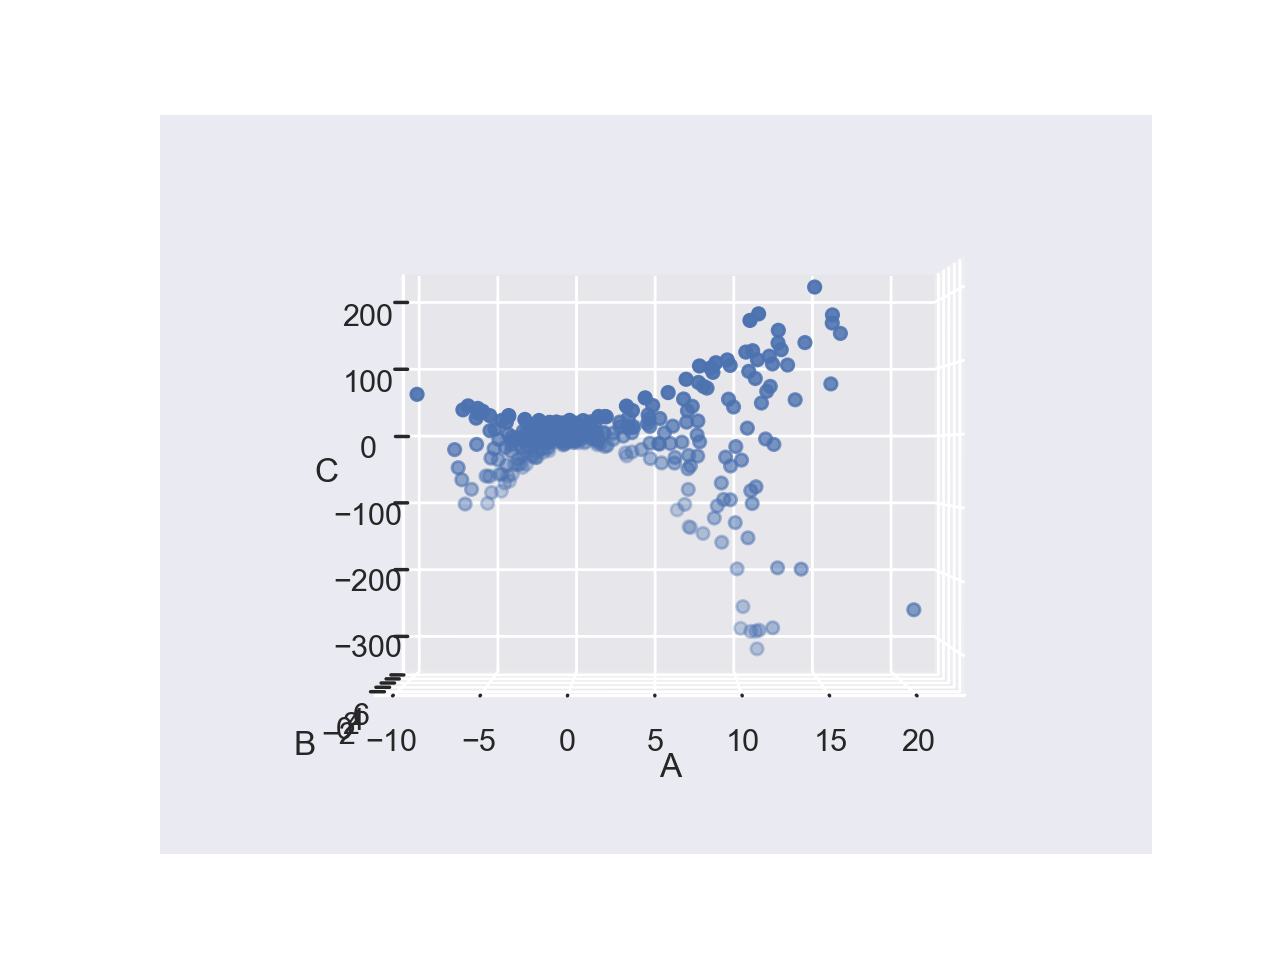

Text(0.5, 0, 'C')

In [266]:
from mpl_toolkits import mplot3d
%matplotlib notebook
ax = plt.axes(projection='3d')
x_data=X.iloc[:,0].values
y_data = X.iloc[:,1].values
z_data = Y.values
ax.scatter3D(x_data,y_data,z_data)
ax.set_xlabel('A')
ax.set_ylabel('B')
ax.set_zlabel('C')
# ax.scatter3D(x_data,y_data,Y_pred)

AttributeError: 'Figure' object has no attribute 'xlabel'

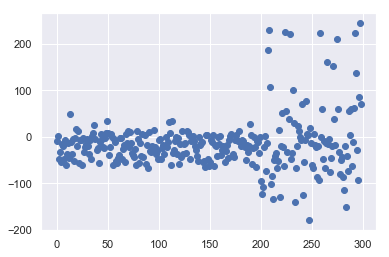

In [293]:
fig,ax = plt.subplots()
plt.scatter(range(len(Y)),Y_pred-Y)
fig.xlabel('A')